In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wget

url = "https://raw.githubusercontent.com/LCAV/pyroomacoustics/master/examples/data/INRIA_MUSIS.stl"
mesh_url = "../tmp/INRIA_MUSIS.stl"

from pathlib import Path
if not Path(mesh_url).is_file():
    print(f"download data to {mesh_url}")
    wget.download(url, mesh_url)
else:
    print("data already downloaded")

data already downloaded


In [38]:
import src.dmcp_workflow.capture_depth as cd

dm, Kdm, Pdm = cd.generate_depth_map(mesh_url)

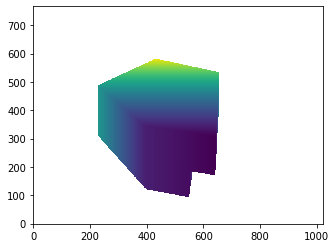

In [41]:
import matplotlib.pyplot as plt

plt.imshow(dm, origin="lower")
plt.show()

In [42]:
import src.dmcp_workflow.annotate_points as ap

cps = ap.annotate(dm, dm)

In [43]:
cps_artificial = cps.copy()

cps_artificial[:,2:4] = cps_artificial[:,:2]
cps_artificial

array([[639.5       , 318.43225806, 639.5       , 318.43225806],
       [382.12365591, 344.5827957 , 382.12365591, 344.5827957 ],
       [397.26344086, 118.86236559, 397.26344086, 118.86236559],
       [537.65053763,  96.84086022, 537.65053763,  96.84086022],
       [548.66129032, 186.30322581, 548.66129032, 186.30322581],
       [639.5       , 186.30322581, 639.5       , 186.30322581]])

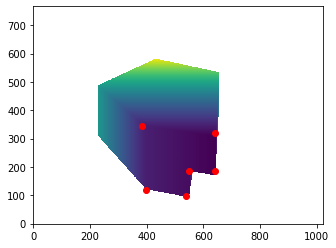

In [45]:
plt.imshow(dm,origin="lower")
plt.scatter(cps_artificial[:,0],cps_artificial[:,1],color="red")

In [46]:
import src.pycv.dmcp as dmcp

world_points = dmcp.dm_to_world(dm, Kdm,Pdm,cps[:,2:])
A = dmcp.dmcp(Kdm, Pdm, cps[:,:2], world_points)

In [47]:
import numpy as np
with np.printoptions(formatter={'float':lambda x: f"{x:10.02f}"}):
    print(f"Transform\n{A}")
    print(f"world points\n{world_points}")

Transform
[[     -0.82      -0.19      -0.54    2375.96]
 [      0.33      -0.93      -0.16   10779.10]
 [     -0.47      -0.31       0.83    2094.72]
 [      0.00       0.00       0.00       1.00]]
world points
[[    -43.02    3852.64    3584.41]
 [  -1566.34    6025.80    4367.20]
 [  -1512.48    5994.42    6256.37]
 [  -1022.61    5281.91    5934.74]
 [   -903.90    5109.89    7201.41]
 [     -6.57    3801.33    6763.20]]


In [48]:
mesh = pv.read(mesh_url)

points = []
def on_click(point):
    points.append(point)

p = pv.Plotter()
p.add_mesh(mesh, pickable=True)
p.enable_point_picking(callback=on_click,pickable_window=False)  # Make the 3D window unpickable
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [50]:
print(np.array(points))

[[-1549.18237305  6047.          2500.        ]
 [-1549.18237305  6047.          1000.01623535]]
